# Quadrotor Control Code

## Imports

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import secrets
import scipy as sc
import control

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

# Deriving Equations of Motion

In [2]:
# Taken from AE 353 DeriveEOM (wes6)

import sympy as sym
import numpy as np

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

In [3]:
# Taken from AE 353 DeriveEOM (wes6)

# Adding Extra Params for Locations of Rotors (lz)

params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.25,
    'g': 9.81,
    'lz': 0.046875,
}

In [4]:
# Taken from AE 353 DeriveEOM (wes6)

# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters (Adding lz) (J is Intertia)
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
lz = sym.nsimplify(params['lz'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices (Tait-Bryant)
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)

f

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                   v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[   

In [5]:
# Taken from AE 353 DeriveEOM (wes6)

# Position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = sym.Matrix([[l], [0.], [lz]])
b_in_body = sym.Matrix([[0.], [l], [lz]])
c_in_body = sym.Matrix([[-l], [0.], [lz]])
d_in_body = sym.Matrix([[0.], [-l], [lz]])

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body
c_in_world = p_in_world + R_body_in_world @ c_in_body
d_in_world = p_in_world + R_body_in_world @ d_in_body

# Sensor model
gy = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world, c_in_world, d_in_world))

gy

Matrix([
[                               p_x + 3*sin(phi)*sin(psi)/64 + 3*sin(theta)*cos(phi)*cos(psi)/64 + cos(psi)*cos(theta)/4],
[                               p_y - 3*sin(phi)*cos(psi)/64 + 3*sin(psi)*sin(theta)*cos(phi)/64 + sin(psi)*cos(theta)/4],
[                                                                          p_z - sin(theta)/4 + 3*cos(phi)*cos(theta)/64],
[p_x + 3*sin(phi)*sin(psi)/64 + sin(phi)*sin(theta)*cos(psi)/4 - sin(psi)*cos(phi)/4 + 3*sin(theta)*cos(phi)*cos(psi)/64],
[p_y + sin(phi)*sin(psi)*sin(theta)/4 - 3*sin(phi)*cos(psi)/64 + 3*sin(psi)*sin(theta)*cos(phi)/64 + cos(phi)*cos(psi)/4],
[                                                                 p_z + sin(phi)*cos(theta)/4 + 3*cos(phi)*cos(theta)/64],
[                               p_x + 3*sin(phi)*sin(psi)/64 + 3*sin(theta)*cos(phi)*cos(psi)/64 - cos(psi)*cos(theta)/4],
[                               p_y - 3*sin(phi)*cos(psi)/64 + 3*sin(psi)*sin(theta)*cos(phi)/64 - sin(psi)*cos(theta)/4],
[      

# Linearization, Equilibrium, LQR, Observer

In [6]:
# Linearization about Equilibrium

p_x_eq = 0
p_y_eq = 0
p_z_eq = 0
psi_eq = 0
theta_eq = 0
phi_eq = 0
v_x_eq = 0
v_y_eq = 0
v_z_eq = 0
w_x_eq = 0
w_y_eq = 0
w_z_eq = 0
tau_x_eq = 0
tau_y_eq = 0
tau_z_eq = 0
f_z_eq = m*9.81        # for force in z direction to equal 0, equilibrium established by equally counteracting gravity

# Verify Equilibrium for f
verify_feq = f.subs(psi,psi_eq).subs(theta,theta_eq).subs(phi,phi_eq).subs(v_x,v_x_eq).subs(v_y,v_y_eq).subs(v_z,v_z_eq).subs(w_x,w_x_eq).subs(w_y,w_y_eq).subs(w_z,w_z_eq).subs(tau_x,tau_x_eq).subs(tau_y,tau_y_eq).subs(tau_z,tau_z_eq).subs(f_z,f_z_eq)
if verify_feq == sym.Matrix([ [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0] ]):
    print('Equilibrium for f!')
else:
    print(verify_feq)

# Verify Equilibrium for gy
verify_gyeq = gy.subs(p_x,p_x_eq).subs(p_y,p_y_eq).subs(p_z,p_z_eq).subs(psi,psi_eq).subs(theta,theta_eq).subs(phi,phi_eq)
gyeq = np.array(verify_gyeq)

# Verifying Equilibrium Points

q_num = sym.lambdify([p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z,tau_x,tau_y,tau_z,f_z],f)
#print(q_num(p_x_eq,p_y_eq,p_z_eq,psi_eq,theta_eq,phi_eq,v_x_eq,v_y_eq,v_z_eq,w_x_eq,w_y_eq,w_z_eq,tau_x_eq,tau_y_eq,tau_z_eq,f_z_eq))

# Calculating A (All States f)

A_num = sym.lambdify((p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z,tau_x,tau_y,tau_z,f_z), f.jacobian([p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z]))
A0 = A_num(p_x_eq,p_y_eq,p_z_eq,psi_eq,theta_eq,phi_eq,v_x_eq,v_y_eq,v_z_eq,w_x_eq,w_y_eq,w_z_eq,tau_x_eq,tau_y_eq,tau_z_eq,f_z_eq)

# Calculating B (All Inputs f)

B_num = sym.lambdify((p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z,tau_x,tau_y,tau_z,f_z), f.jacobian([tau_x,tau_y,tau_z,f_z]))
B0 = B_num(p_x_eq,p_y_eq,p_z_eq,psi_eq,theta_eq,phi_eq,v_x_eq,v_y_eq,v_z_eq,w_x_eq,w_y_eq,w_z_eq,tau_x_eq,tau_y_eq,tau_z_eq,f_z_eq)

# Calculating C (All States gy)

C_num = sym.lambdify((p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z,tau_x,tau_y,tau_z,f_z), gy.jacobian([p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z]))
C0 = C_num(p_x_eq,p_y_eq,p_z_eq,psi_eq,theta_eq,phi_eq,v_x_eq,v_y_eq,v_z_eq,w_x_eq,w_y_eq,w_z_eq,tau_x_eq,tau_y_eq,tau_z_eq,f_z_eq)

# Calculating D (All Inputs gy)

D_num = sym.lambdify((p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z,tau_x,tau_y,tau_z,f_z), gy.jacobian([tau_x,tau_y,tau_z,f_z]))
D0 = D_num(p_x_eq,p_y_eq,p_z_eq,psi_eq,theta_eq,phi_eq,v_x_eq,v_y_eq,v_z_eq,w_x_eq,w_y_eq,w_z_eq,tau_x_eq,tau_y_eq,tau_z_eq,f_z_eq)

# Final Result:

A = A0
B = B0
C = C0
D = D0


Equilibrium for f!


In [7]:
# Verifying Controllability and Observability

# Because Controllability implies Stability, we only test Controllability

def controllability_matrix(A, B):
    n = A.shape[0]
    controllability_mat = B
    for i in range(1, n):
        controllability_mat = np.hstack((controllability_mat, np.linalg.matrix_power(A, i) @ B))
    return controllability_mat

W = controllability_matrix(A,B)

# Check if W is square

if W.shape[0] == W.shape[1]:
    print('square')
else:
    print('W not square, must determine rank')

# Determine if W is full rank

rank_W = np.linalg.matrix_rank(W)
if rank_W == W.shape[0]:
    print('W FULL RANK, CONTROLLABLE AND ALSO STABILIZABLE')
else:
    print('W NOT FULL RANK, UNCONTROLLABLE')

    
# Verify Observability

def observability_matrix(A, C):
    A = A.T
    C = C.T
    n = A.shape[0]
    controllability_mat = C
    for i in range(1, n):
        controllability_mat = np.hstack((controllability_mat, np.linalg.matrix_power(A, i) @ C))
    return controllability_mat

O_W = observability_matrix(A,C)

print(W)

# Check if O_W is square

if O_W.shape[0] == O_W.shape[1]:
    print('square')
else:
    print('W not square, must determine rank')

# Determine if O_W is full rank

rank_O_W = np.linalg.matrix_rank(O_W)
if rank_O_W == O_W.shape[0]:
    print('O_W FULL RANK, OBSERVABLE AND ALSO DETECTABLE')
else:
    print('O_W NOT FULL RANK, UNOBSERVABLE')

W not square, must determine rank
W FULL RANK, CONTROLLABLE AND ALSO STABILIZABLE
[[    0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.         4265.2173913     0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.       ]
 [    0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.        -4265.2173913     0.            0.
      0.            0.            0.            0.            0.
      0.            0.      

In [8]:
# Compute K using LQR

# Establish Q Values and make Q

# MESS WITH THESE FOR STATE OUTPUT !!!!!!!!!!!!!!!!
# DO NOT CHANGE CURRENT VALUES WITHOUT TAKING A PICTURE OF THEM OR SOMETHING

Q1 = 5           # p_x , x position                                     
Q2 = 5          # p_y , y position                                    
Q3 = 5          # p_z , z position                           
Q4 = 70          # psi , yaw angle                       
Q5 = 70           # theta , pitch angle                          
Q6 = 70           # phi , roll angle                    
Q7 = 1.75           # v_x , linear velocity along the body-fixed x axis                             
Q8 = 1.75          # v_y , linear velocity along the body-fixed y axis                        
Q9 = 1.75         # v_z , linear velocity along the body-fixed z axis                    
Q10 = 0.1         # w_x , angular velocity about the body-fixed x axis (rad/s), which points forward   
Q11 = 0.1       # w_y , angular velocity about the body-fixed y axis (rad/s), which points left     
Q12 = 0.1          # w_z , angular velocity about the body-fixed z axis (rad/s), which points up  

Q = np.diag([ Q1, Q2 , Q3 , Q4 , Q5 , Q6 , Q7 , Q8 , Q9 , Q10 , Q11 , Q12 ])

# R, for K = R_inv * B^T * P

# MESS WITH THESE FOR TORQUE OUTPUT !!!!!!!!!!!!!!!!
# DO NOT CHANGE CURRENT VALUES WITHOUT TAKING A PICTURE OF THEM OR SOMETHING
R1 = 650      
R2 = 650     
R3 = 650      
R4 = 1

R = np.diag([ R1 , R2 , R3 , R4 ])


# CARE Equation

P = sc.linalg.solve_continuous_are( A,B,Q,R )

# K

K = np.linalg.inv(R) @ B.T @ P

# Verifying Asymptotic Stability:

x_dot = A - B @ K

eigenvalues = np.linalg.eigvals(x_dot)
for i in eigenvalues:
    if np.real(i) < 0:
        print(f'{i} is GOOD')
    else:
        print(i)

sym.Matrix(K)

(-8.825242429645076+8.034071769435586j) is GOOD
(-8.825242429645076-8.034071769435586j) is GOOD
(-8.825242429645098+8.034071769435608j) is GOOD
(-8.825242429645098-8.034071769435608j) is GOOD
(-6.589725249277445+6.2142406256333516j) is GOOD
(-6.589725249277445-6.2142406256333516j) is GOOD
(-1.3836637059732846+0.8437390744188314j) is GOOD
(-1.3836637059732846-0.8437390744188314j) is GOOD
(-1.3836637059732748+0.8437390744188384j) is GOOD
(-1.3836637059732748-0.8437390744188384j) is GOOD
(-1.996513956249694+0.697185755376412j) is GOOD
(-1.996513956249694-0.697185755376412j) is GOOD


Matrix([
[-1.27203065410824e-16,   -0.0877058019307037,  1.49446899794623e-16, 1.20455140215725e-15,  3.18600650821183e-16,    0.445975300581474, 5.56589372542179e-17,    -0.103279941429311,  8.87555673417195e-17,   0.0469609682238445,  1.86909811688306e-17, 1.64446700330247e-16],
[   0.0877058019307028, -1.54278604723321e-16, -3.08655111284307e-17, 8.33620265320106e-17,     0.445975300581471, 9.78868965831812e-17,    0.103279941429311, -4.94163276348695e-17, -1.79114895274063e-17, 1.86909811688306e-17,    0.0469609682238444, 8.78852035467261e-18],
[ 1.64277541365107e-16, -1.20109297444774e-16,  2.36809982960346e-16,    0.328165061656946,  7.72236717484246e-17, 1.37458305367802e-15, 8.55593182749742e-17, -2.48777224295119e-16,  9.42374557271547e-17, 9.45568526898919e-17,  5.05339920393675e-18,   0.0527178019942195],
[  -2.442325401479e-16,  -2.0289236342892e-15,      2.23606797749979, 1.23463594294168e-15, -4.97064963769384e-16, 3.87854624273847e-15, 1.34048303624094e-16, -1.8092679145

In [9]:
# Compute L using Observer Equations

# Re-define new matrices

R_O = np.identity(A.shape[0])

Q_O = np.identity(C.shape[0])

# Computing L
L, _, _ = control.lqr(A.T, C.T, Q_O, R_O)
L = L.T

# Verify if fully Detectable

Ob_x = A - L @ C

eigenvalues_obx = np.linalg.eigvals(Ob_x)
for i in eigenvalues_obx:
    if np.real(i) < 0:
        print(f'{i} is GOOD')
    else:
        print(i)

sym.Matrix(L)

(-1.4068280141563287+2.170216694564989j) is GOOD
(-1.4068280141563287-2.170216694564989j) is GOOD
(-1.4068280141563414+2.1702166945649775j) is GOOD
(-1.4068280141563414-2.1702166945649775j) is GOOD
(-2.931308194945014+0j) is GOOD
(-2.9313081949449544+0j) is GOOD
(-0.5590169943749457+0.4330127018922194j) is GOOD
(-0.5590169943749457-0.4330127018922194j) is GOOD
(-1.4142135623730925+6.419035703525806e-08j) is GOOD
(-1.4142135623730925-6.419035703525806e-08j) is GOOD
(-1.0012852783574153+0j) is GOOD
(-1.001285278357437+0j) is GOOD


Matrix([
[      1.6029062077909, 7.12616550850771e-16,    -0.190234588600968,       1.6029062077909, 7.10004354952669e-16, -4.29740897678632e-16,       1.6029062077909, 7.07392159054567e-16,     0.190234588600968,       1.6029062077909, 7.10004354952669e-16, -5.09341580732531e-16],
[ 7.58645890002514e-16,      1.6029062077909,  1.96592957655545e-15,  1.08468739605647e-16,      1.6029062077909,    -0.190234588600965,  7.58645890002514e-16,      1.6029062077909,  2.40517193403324e-15,  1.40882304039938e-15,      1.6029062077909,     0.190234588600969],
[-4.87170508838937e-16, 2.44848129928746e-15,     0.707106781186546, -6.73765355070789e-16, 2.26188645305561e-15,     0.707106781186545, -4.87170508838937e-16, 2.07529160682376e-15,     0.707106781186546, -3.00575662607085e-16, 2.26188645305561e-15,     0.707106781186546],
[-4.10484061624365e-17,     1.11803398874989,  1.02103106361991e-15,     -1.11803398874989,  2.6229342171226e-15,  6.27842768740031e-16, -4.10484061624365e-17,    -1.118

In [10]:
# Shape Testing Box

print(A.shape,
      B.shape,
      C.shape,
      K.shape,
      L.shape,
      (np.array([1,1,1,1,0,0,0,0,0,0,0,0])).shape,
      (C @ np.array([1,1,1,1,0,0,0,0,0,0,0,0])).shape,
     (L @ (C @ np.array([1,1,1,1,0,0,0,0,0,0,0,0]))).shape)


(12, 12) (12, 4) (12, 12) (4, 12) (12, 12) (12,) (12,) (12,)


# Controller

Define a controller for the drone.

In [11]:
class Controller:

    # NEVER CHANGE THIS
    def __init__(self):
        """
        List all class variables you want the simulator to log. For
        example, if you want the simulator to log "self.xhat", then
        do this:
        
            self.variables_to_log = ['xhat']
        
        Similarly, if you want the simulator to log "self.xhat" and
        "self.y", then do this:
        
            self.variables_to_log = ['xhat', 'y']
        
        Etc. These variables have to exist in order to be logged.
        """

        # Choose time step
        self.dt = 0.01

        self.variables_to_log = ['xhat', 'xhat_cushioned']
        
        # Define equilibrium points
        self.p_x_eq = p_x_eq
        self.p_y_eq = p_y_eq
        self.p_z_eq = p_z_eq
        self.psi_eq = psi_eq
        self.theta_eq = theta_eq
        self.phi_eq = phi_eq
        self.v_x_eq = v_x_eq
        self.v_y_eq = v_y_eq
        self.v_z_eq = v_z_eq
        self.w_x_eq = w_x_eq
        self.w_y_eq = w_y_eq
        self.w_z_eq = w_z_eq
        self.tau_x_eq = tau_x_eq
        self.tau_y_eq = tau_y_eq
        self.tau_z_eq = tau_z_eq
        self.f_z_eq = 9.81 * 0.5
        
        # Define state-space model
        self.A = A
        self.B = B
        self.C = C
        
        # Define controller and observer gains
        self.K = K
        self.L = L

        # Run Function Variables
        self.PGN = 2                      # For testing [PG1 = 0] ; [PG2 = 2] ; [PG3 = 4]
        self.theta = np.pi                # Starting Angle ... DO NOT CHANGE
        self.radius = 2                   # Performance Goal Requirement
        self.circularspeed = 0.50         # Performance Goal Requirement
        self.timerstart = 0               # Starting time for Performance Goal 1 ... DO NOT CHANGE
        self.timerstart2 = 0              # Starting time for Performance Goal 2 ... DO NOT CHANGE
        self.PGN2_avgvel_list = []        # List used to collect the velocity at every time step in Performance Goal 2 ... DO NOT CHANGE
        self.PGN3_avgvel_list = []        # List used to collect the velocity at every time step in Performance Goal 3 ... DO NOT CHANGE
        self.radius_list = []             # List used to collect the radius at every time step in Performance Goal 2 ... DO NOT CHANGE

    
    # NEVER CHANGE THIS
    def reset(self, p_x = 0, p_y = 0, p_z = 0, yaw = 0):

        # Initialize the state estimate (12 States, Initial 4 Given Above)
        self.xhat = np.array([p_x,p_y,p_z,yaw,0,0,0,0,0,0,0,0], dtype=np.float64)

        # Initialize the cushioning x-position statement
        self.xhat_cushioned = np.array([0,0,0,0,0,0,0,0,0,0,0,0], dtype=np.float64)
        
        pass

    # Run Function ... Drone behavior is written here        
    def run(self, **kwargs):
        """
        kwargs is a dictionary containing lists of data from ae353_quadrotor.py 
        
        """

        # Defining Initial Values
        xhat_cushval = np.zeros(12)
        
        # Defining kwargs values
        mocap1 = kwargs["mocap_1"]
        mocap2 = kwargs["mocap_2"]
        mocap3 = kwargs["mocap_3"]
        mocap4 = kwargs["mocap_4"]
        next_gate = kwargs["next_gate"]
        dir_gate = kwargs["dir_gate"]
        is_last_gate = kwargs["is_last_gate"]
        pos_others = kwargs["pos_others"]

        # Positions of Each Rotor
        pos_markers = np.array([ mocap1[0] , mocap1[1] , mocap1[2] ,   # +x
                                 mocap2[0] , mocap2[1] , mocap2[2] ,   # +y
                                 mocap3[0] , mocap3[1] , mocap3[2] ,   # -x
                                 mocap4[0] , mocap4[1] , mocap4[2] ])  # -y


        # Start of Performance Goal 1 ---------

        # Fly up 1m
        if self.PGN == 0:
            curr_pos_PG1 = np.array([ self.xhat[0] , self.xhat[1] , self.xhat[2] ])      # Current Position Estimate
            goal_location = np.array([ 0 , 0 , 1 ])                                      # Hover 1m above the ground
            goal_state = np.concatenate((goal_location, np.zeros(9)))
        
            dist_to_goal = goal_location - curr_pos_PG1                             # Full Magnitude Distance to Hover Location
            dist_to_goal_mag = np.linalg.norm(dist_to_goal)                          # Normalized Distance to Hover Location
    
            # Approach Cushioning Function
            pos_approach_val = 0.01          # Coefficient used to slowly change the desired position
                
            if dist_to_goal_mag > 0.1:
                pos_cush = curr_pos_PG1 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.5 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.075:
                pos_cush = curr_pos_PG1 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.275 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.05:
                pos_cush = curr_pos_PG1 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.05 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.03:
                pos_cush = curr_pos_PG1 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.03 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.01:
                pos_cush = curr_pos_PG1 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.007 * ( dist_to_goal / dist_to_goal_mag )
            else:
                pos_cush = goal_location
                vel_cush = 0 * ( dist_to_goal / dist_to_goal_mag )
                print('Successfully ascended to 1m above the ground ...')
                self.PGN = 1

            xhat_cushval[0:3] = pos_cush
            xhat_cushval[6:9] = vel_cush
            self.xhat_cushioned = xhat_cushval

        # Hover for 2 minutes
        if self.PGN == 1:

            self.timerstart += self.dt

            curr_pos_PG1 = np.array([ self.xhat[0] , self.xhat[1] , self.xhat[2] ])      # Current Position Estimate
            curr_angle_PG1 = np.array([ self.xhat[3] , self.xhat[4] , self.xhat[5] ])
            goal_location = np.array([ 0 , 0 , 1 ])                                 # Hover 1m above the ground
            goal_angle = np.array([0 , 0 , 0])
            goal_state = np.concatenate((goal_location, np.zeros(9)))
        
            dist_to_goal = goal_location - curr_pos_PG1                             # Full Magnitude Distance to Hover Location
            dist_to_goal_mag = np.linalg.norm(dist_to_goal)                          # Normalized Distance to Hover Location
            angular_goal_err = goal_angle - curr_angle_PG1
            mag_angular_goal_err = np.linalg.norm(angular_goal_err)

            if self.timerstart < 120.0:
                # Approach Cushioning Function
                pos_approach_val = 0.01            # Coefficient used to slowly change the desired position
                    
                if dist_to_goal_mag > 0.1:
                    pos_cush = curr_pos_PG1 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                    vel_cush = 0.5 * ( dist_to_goal / dist_to_goal_mag )
                elif dist_to_goal_mag > 0.075:
                    pos_cush = curr_pos_PG1 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                    vel_cush = 0.275 * ( dist_to_goal / dist_to_goal_mag )
                elif dist_to_goal_mag > 0.05:
                    pos_cush = curr_pos_PG1 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                    vel_cush = 0.05 * ( dist_to_goal / dist_to_goal_mag )
                elif dist_to_goal_mag > 0.03:
                    pos_cush = curr_pos_PG1 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                    vel_cush = 0.03 * ( dist_to_goal / dist_to_goal_mag )
                elif dist_to_goal_mag > 0.01:
                    pos_cush = curr_pos_PG1 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                    vel_cush = 0.007 * ( dist_to_goal / dist_to_goal_mag )
                else:
                    pos_cush = goal_location
                    vel_cush = 0 * ( dist_to_goal / dist_to_goal_mag )
                

                xhat_cushval[0:3] = pos_cush
                xhat_cushval[6:9] = vel_cush
                self.xhat_cushioned = xhat_cushval

            if 60.0 <= self.timerstart < 60.01:
                print('1 minute remaining ...')
            
            elif 120.0 <= self.timerstart < 120.01:
                print('2 minutes hovering complete!')
                

        # End of Performance Goal 1 ---------


        
        # Start of Performance Goal 2 ---------

        # Fly up 1m
        if self.PGN == 2:

            curr_pos_PG2 = np.array([ self.xhat[0] , self.xhat[1] , self.xhat[2] ])      # Current Position Estimate
            goal_location = np.array([ 0 , 0 , 1 ])                                 # Hover 1m above the ground
            goal_state = np.concatenate((goal_location, np.zeros(9)))
        
            dist_to_goal = goal_location - curr_pos_PG2                             # Full Magnitude Distance to Hover Location
            dist_to_goal_mag = np.linalg.norm(dist_to_goal)                          # Normalized Distance to Hover Location
    
            # Approach Cushioning Function
            pos_approach_val = 0.01              # Coefficient used to slowly change the desired position
                
            if dist_to_goal_mag > 0.1:
                pos_cush = curr_pos_PG2 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.5 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.075:
                pos_cush = curr_pos_PG2 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.275 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.05:
                pos_cush = curr_pos_PG2 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.05 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.03:
                pos_cush = curr_pos_PG2 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.03 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.01:
                pos_cush = curr_pos_PG2 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.007 * ( dist_to_goal / dist_to_goal_mag )
            else:
                pos_cush = goal_location
                vel_cush = 0 * ( dist_to_goal / dist_to_goal_mag )
                print('Successfully ascended to 1m above the ground ...')
                self.PGN = 3

            xhat_cushval[0:3] = pos_cush
            xhat_cushval[6:9] = vel_cush
            self.xhat_cushioned = xhat_cushval

        # Fly in a circle of radius 2m at 0.5 m/s
        if self.PGN == 3:
            
            self.timerstart2 += self.dt
            
            curr_pos_PG2 = np.array([ self.xhat[0] , self.xhat[1] , self.xhat[2] ])      # Current Position
            curr_vel_PG2 = np.array([ self.xhat[6] , self.xhat[7] , self.xhat[8] ])      # Current Linear Velocities

            center = np.array([self.radius, 0, 1])                                       # Center of Circle

            mag_vel_PG2 = np.linalg.norm(curr_vel_PG2)                                   # Magnitude of Velocity
            self.PGN2_avgvel_list.append(mag_vel_PG2)                                    # Adding to list at every time step
            
            radius = np.linalg.norm(center - curr_pos_PG2)                               # Radial Distance to center
            self.radius_list.append(radius)                                              # Adding to list at every time step
            
            omega = self.circularspeed / self.radius                                     # Calculating Necessary Angular Velocity

            # Angle Cushion Function
            self.theta += omega * self.dt
            self.theta = self.theta % (2*np.pi)                                          # Keep looping through 0 to 2*pi

            new_x = center[0] + self.radius * np.cos(self.theta)
            new_y = center[1] + self.radius * np.sin(self.theta)

            goal_pos = np.array([ new_x , new_y , center[2]])
            
            dist_gp = goal_pos - curr_pos_PG2
            norm_dist_gp = np.linalg.norm(dist_gp)

            # Approach Cushioning Function
            pos_approach_val = 0.01                    # Coefficient used to slowly change the desired position

            norm_vel = np.linalg.norm(curr_vel_PG2)

            pos_cush = curr_pos_PG2 + pos_approach_val * ( dist_gp / norm_dist_gp )
            vel_cush = (self.circularspeed) * ( dist_gp / norm_dist_gp )

                          
            xhat_cushval[0:3] = pos_cush
            xhat_cushval[6:9] = vel_cush
            self.xhat_cushioned = xhat_cushval

            if 30.0 <= self.timerstart2 < 30.01:
                print('30 seconds remaining ...')
            
            elif 60.0 <= self.timerstart2 < 60.01:
                print('1 minute flying in a circle complete!')
                avg_rad = sum(self.radius_list) / len(self.radius_list)
                avgveloc = sum(self.PGN2_avgvel_list) / len(self.PGN2_avgvel_list)
                print(f'The average radius during flight was {avg_rad}m')
                print(f'The average velocity during flight was {avgveloc}m/s')

        # End of Performance Goal 2 ---------


        # Start of Performance Goal 3 ---------

        # Fly up 1m
        if self.PGN == 4:

            curr_pos_PG3 = np.array([ self.xhat[0] , self.xhat[1] , self.xhat[2] ])      # Current Position Estimate
            goal_location = np.array([ 0 , 0 , 1 ])                                 # Hover 1m above the ground
            goal_state = np.concatenate((goal_location, np.zeros(9)))
        
            dist_to_goal = goal_location - curr_pos_PG3                             # Full Magnitude Distance to Hover Location
            dist_to_goal_mag = np.linalg.norm(dist_to_goal)                          # Normalized Distance to Hover Location
    
            # Approach Cushioning Function
            pos_approach_val = 0.01                     # Coefficient used to slowly change the desired position
                
            if dist_to_goal_mag > 0.1:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.5 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.075:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.275 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.05:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.05 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.03:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.03 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.01:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.007 * ( dist_to_goal / dist_to_goal_mag )
            else:
                pos_cush = goal_location
                vel_cush = 0 * ( dist_to_goal / dist_to_goal_mag )
                print('Successfully ascended to 1m above the ground ...')
                self.PGN = 5

            xhat_cushval[0:3] = pos_cush
            xhat_cushval[6:9] = vel_cush
            self.xhat_cushioned = xhat_cushval

        # Move 5m out at 1 m/s ... THE 1 M/S REQUIREMENT IS NOT MET
        if self.PGN == 5:

            curr_vel_PG3 = np.array([ self.xhat[6] , self.xhat[7] , self.xhat[8] ])
            mag_vel_PG3 = np.linalg.norm(curr_vel_PG3)
            self.PGN3_avgvel_list.append(mag_vel_PG3)
            
            
            curr_pos_PG3 = np.array([ self.xhat[0] , self.xhat[1] , self.xhat[2] ])      # Current Position Estimate
            goal_location = np.array([ 5 , 0 , 1 ])                                 # Fly 5m out
            goal_state = np.concatenate((goal_location, np.zeros(9)))
        
            dist_to_goal = goal_location - curr_pos_PG3                             # Full Magnitude Distance to Goal Location
            dist_to_goal_mag = np.linalg.norm(dist_to_goal)                          # Normalized Distance to Goal Location
    
            # Approach Cushioning Function ... PLAY WITH THESE NUMBERS OR ADD MORE "elif" STATEMENTS FOR AN AVERAGE OF 1m/s
            pos_approach_val = 0.01
            
            if dist_to_goal_mag > 4.5:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.5 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 4.4:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.8 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 4.3:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 1.0 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 4.2:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 1.2 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 4.1:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 1.4 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 4.0:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 1.6 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 1.0:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 1.0 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.8:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.8 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.6:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.6 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.4:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.4 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.2:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.2 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.1:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.1 * ( dist_to_goal / dist_to_goal_mag )
            elif dist_to_goal_mag > 0.05:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.05 * ( dist_to_goal / dist_to_goal_mag )
            else:
                pos_cush = goal_location
                vel_cush = 0 * ( dist_to_goal / dist_to_goal_mag )
                print('Successfully moved 5m and stopped ...')
                avg_velocity_flying = sum(self.PGN3_avgvel_list) / len(self.PGN3_avgvel_list)
                print(f'The drone flew 5m at {avg_velocity_flying} m/s')
                self.PGN = 6

            xhat_cushval[0:3] = pos_cush
            xhat_cushval[6:9] = vel_cush
            self.xhat_cushioned = xhat_cushval

        # Yaw 90 degrees --- CURRENTLY INCOMPLETE / NOT WORKING . Typically, PGN = 6, but skipped to next step because NOT WORKING
        if self.PGN == 100:
            
            curr_pos_PG3 = np.array([ self.xhat[0] , self.xhat[1] , self.xhat[2] ])      # Current Position Estimate
            goal_location = np.array([ 5 , 0 , 1 ])                                 # Fly 5m out
            goal_state = np.concatenate((goal_location, np.zeros(9)))
        
            dist_to_goal = goal_location - curr_pos_PG3                             # Full Magnitude Distance to Hover Location
            dist_to_goal_mag = np.linalg.norm(dist_to_goal)                          # Normalized Distance to Hover Location

            pos_cush = goal_location
            vel_cush = 0 * ( dist_to_goal / dist_to_goal_mag )

            # Angle Implementation
            curr_ang = np.array([ self.xhat[3] , self.xhat[4] , self.xhat[5] ])
            goal_ang = np.array([ -np.pi/2 , 0 , 0 ])

            dist_ang = goal_ang - curr_ang
            norm_da = np.linalg.norm(dist_ang)
            uv_ang = dist_ang / norm_da

            if norm_da > 0.1:
                ang_cush = curr_ang + 0.01 * goal_ang
            else:
                ang_cush = goal_ang
                print('Successfully yawed 90 degrees')
            
            xhat_cushval[0:3] = pos_cush
            xhat_cushval[3:6] = ang_cush
            xhat_cushval[6:9] = vel_cush
            self.xhat_cushioned = xhat_cushval

        # Land at a velocity of 0.01 m/s
        if self.PGN == 6:

            curr_pos_PG3 = np.array([ self.xhat[0] , self.xhat[1] , self.xhat[2] ])      # Current Position Estimate
            goal_location = np.array([ 5 , 0 , 0 ])                                 # Hover 1m above the ground
            goal_state = np.concatenate((goal_location, np.zeros(9)))
        
            dist_to_goal = goal_location - curr_pos_PG3                             # Full Magnitude Distance to Hover Location
            dist_to_goal_mag = np.linalg.norm(dist_to_goal)                          # Normalized Distance to Hover Location
    
            # Approach Cushioning Function
            pos_approach_val = 0.01
                
            if dist_to_goal_mag > 0.1:
                pos_cush = curr_pos_PG3 + pos_approach_val * ( dist_to_goal / dist_to_goal_mag )
                vel_cush = 0.01 * ( dist_to_goal / dist_to_goal_mag )
            else:
                pos_cush = goal_location
                vel_cush = 0 * ( dist_to_goal / dist_to_goal_mag )
                print('Successfully descended to the ground ...')
                self.PGN = 7


            xhat_cushval[0:3] = pos_cush
            xhat_cushval[6:9] = vel_cush
            self.xhat_cushioned = xhat_cushval

        # Checks to make sure drone has landed and all other states are 0
        if self.PGN == 7:

            goal_location = np.array([ 5 , 0 , 0 ])
            goal_state = np.concatenate((goal_location, np.zeros(9)))

            xhat_cushval = goal_state
            self.xhat_cushioned = xhat_cushval      # End State
            self.PGN = 'end'
        
        
        # Apply controller
        u = np.array(-self.K@(self.xhat - self.xhat_cushioned))                        # State Estimate - Guidance Error

        y_expected = self.C @ self.xhat
        y_measured = pos_markers
        y = y_expected - y_measured

        # Apply observer to update state estimate
        self.xhat += (self.A@self.xhat+self.B@u-self.L@(y))*self.dt

        tau_x = u[0]                                                              # Torque in x direction
        tau_y = u[1]                                                              # Torque in y direction
        tau_z = u[2]                                                              # Torque in z direction
        f_z = u[3] + self.f_z_eq                                                  # Body Force in z direction

        # Attempt at limitting the wobbling of drone when yawing
        if self.PGN == 100:
            tau_x = 0.45 * tau_x
            tau_y = 0.45 * tau_y
            tau_z = 1.0 * tau_z

        # PG3 : Stops drone motion
        if self.PGN == 'end':
            tau_x = 0
            tau_y = 0
            tau_z = 0
            f_z = 0
        

        return tau_x, tau_y, tau_z, f_z

# Simulator

## Delete none of the simulation code

In [12]:
# Create an instance of our Controller class to simulate 1 quadrotor
controller1 = Controller()

In [13]:
# Import the quadrotor project. This module is used to simulate, render, and plot a quadrotor dynamic system
import ae353_quadrotor

In [14]:
# Make an instance of the simulator for 1 quadrotor
team_list = [""]
sim = ae353_quadrotor.Quadrotor_Sim(n_quadrotors=1,
                                    team_list=team_list,
                                    planet="Earth",
                                    use_keyboard=True,
                                    visualization=True,
                                    visualization_fr=45.,
                                    animation=False,
                                    verbose=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [15]:
# Run the simulation and collect the simulation data\
controllers = [controller1]
(track_stats, data) = sim.run(controllers,
                              sensor_noise=0.00,
                              collect_data=True,
                              max_time=1400.0,
                              verbose=True)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
Successfully ascended to 1m above the ground ...
30 seconds remaining ...
1 minute flying in a circle complete!
The average radius during flight was 1.9937181635660322m
The average velocity during flight was 0.4992427767129761m/s
QUITTING...
Termination command detected. Terminating keyboard listener. Goodbye


# Graphing Data

After the simulation is run, we can plot the data using the Matplotlib package. To start, we import matplotlib and numpy.

In [16]:
# Import the pyplot module from the matplotlib package
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

## ** GRAPH CODE BELOW **

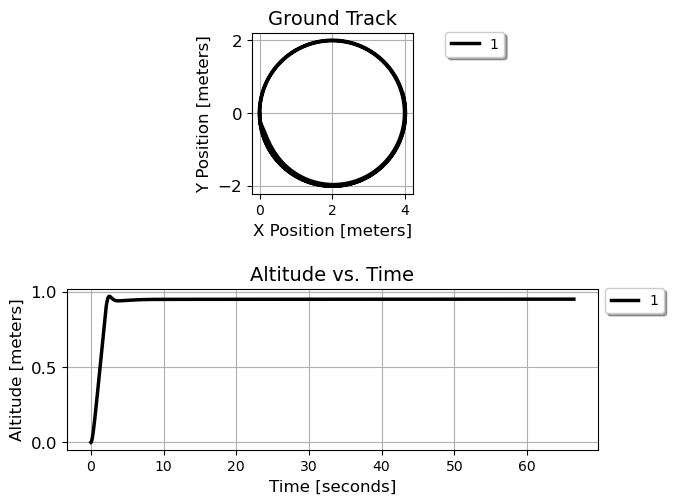

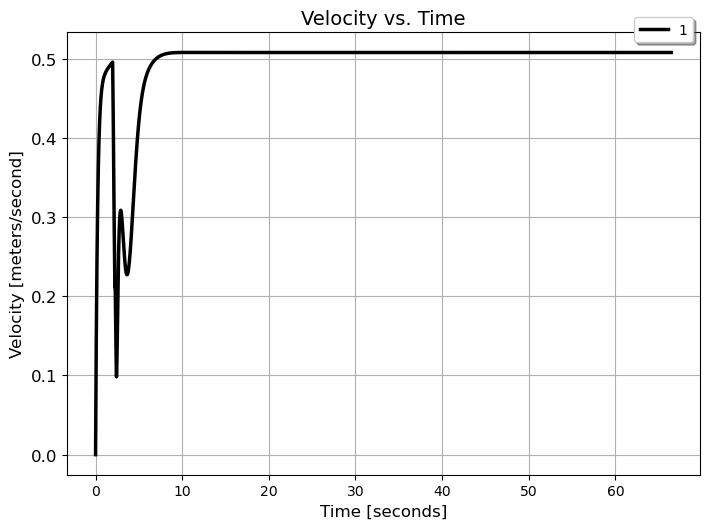

Average Velocity from start to finish was 0.4943382968617988


In [17]:
velocity_list = []
mag_velocity_list = []

# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=False)

# Convert the position data to array
colors = ['k','r','g','b','m','c','tab:orange','tab:purple','tab:brown','tab:pink','tab:gray']
for i in range(len(data)):
    
    # Get the position
    pos = np.array(data[i]['position'])
    
    # Create a plot of the ground path of the quadrotor
    axes[0].plot(pos[:,0], pos[:,1], c=colors[i], lw=2.5, label=str(i+1))
    
    # Create a plot of the altitude versus time
    axes[1].plot(data[0]['time'], pos[:,2], c=colors[i], lw=2.5, label=str(i+1))

# Make plot 0 pretty
axes[0].set_xlabel("X Position [meters]", fontsize=12)
axes[0].set_ylabel("Y Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Ground Track", fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].legend(bbox_to_anchor=(1.16, 1.05), fancybox=True, shadow=True)
axes[0].grid()

# Make plot 1 pretty
axes[1].set_xlabel("Time [seconds]", fontsize=12)
axes[1].set_ylabel("Altitude [meters]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Altitude vs. Time", fontsize=14)
axes[1].legend(bbox_to_anchor=(1., 1.05), fancybox=True, shadow=True)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()



# Adding Velovity Tracking

# Create a figure that has two plots in it
fig, axes_velocity = plt.subplots(1, figsize=(7.2, 5.4), sharex=True)

# Adding Velovity Tracking
for i in range(len(data)):

    # Get velocity
    velocity = np.array(data[i]['velocity'])
    for j in velocity:
        velocity_list.append(j)
    vel_mag = np.linalg.norm(velocity, axis = 1)

    # Create a plot of the velocity versus time
    axes_velocity.plot(data[0]['time'], vel_mag, c=colors[i], lw=2.5, label=str(i+1))

# Make the plot pretty
axes_velocity.set_xlabel("Time [seconds]", fontsize=12)
axes_velocity.set_ylabel("Velocity [meters/second]", fontsize=12)
axes_velocity.tick_params(axis='y', labelsize=12)
axes_velocity.set_title("Velocity vs. Time", fontsize=14)
axes_velocity.legend(bbox_to_anchor=(1.0, 1.05), fancybox=True, shadow=True)
axes_velocity.grid()

plt.tight_layout()
plt.show()

for i in velocity_list:
    mag = np.linalg.norm(i)
    mag_velocity_list.append(mag)

average_velocity = sum(mag_velocity_list)/len(mag_velocity_list)

print(f'Average Velocity from start to finish was {average_velocity}')
    

KeyError: 'euler_angles'

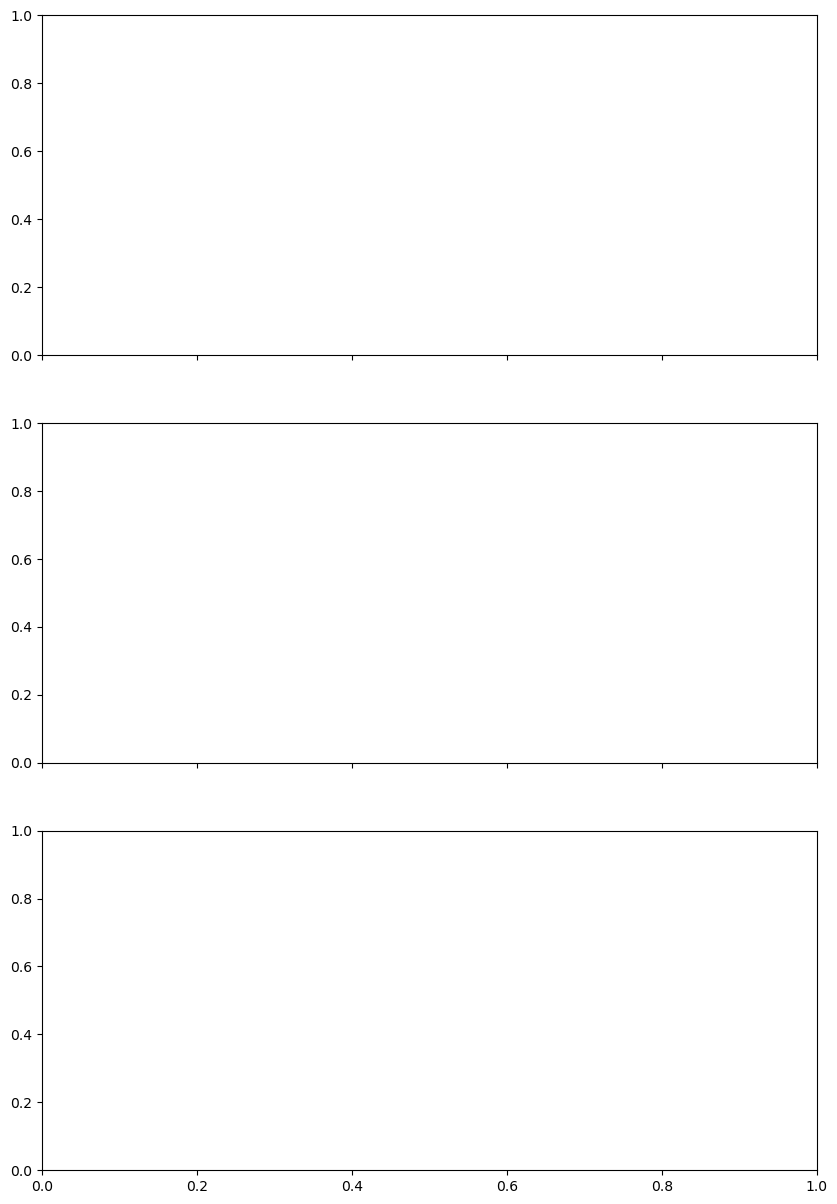

In [21]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, figsize=(10, 15), sharex=True)

# Convert the position data to array
colors = ['k','r','g','b','m','c','tab:orange','tab:purple','tab:brown','tab:pink','tab:gray']

for i in range(len(data)):
    euler_angles = np.array(data[i]['euler_angles'])
    time = data[0]['time']
    
    
    axes[0].plot(time, euler_angles[:,0], c=colors[i], lw=2.5, label=f'Component {i+1} - Roll')
    axes[1].plot(time, euler_angles[:,1], c=colors[i], lw=2.5, label=f'Component {i+1} - Pitch')
    axes[2].plot(time, euler_angles[:,2], c=colors[i], lw=2.5, label=f'Component {i+1} - Yaw')


axes[0].set_ylabel("Roll [degrees or radians]", fontsize=12)
axes[0].set_title("Roll vs. Time", fontsize=14)
axes[0].legend(loc='upper right', fancybox=True, shadow=True)
axes[0].grid(True)

axes[1].set_ylabel("Pitch [degrees or radians]", fontsize=12)
axes[1].set_title("Pitch vs. Time", fontsize=14)
axes[1].legend(loc='upper right', fancybox=True, shadow=True)
axes[1].grid(True)

axes[2].set_xlabel("Time [seconds]", fontsize=12)
axes[2].set_ylabel("Yaw [degrees or radians]", fontsize=12)
axes[2].set_title("Yaw vs. Time", fontsize=14)
axes[2].legend(loc='upper right', fancybox=True, shadow=True)
axes[2].grid(True)


fig.tight_layout()
plt.show()